In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Data Loading & Understanding

In [207]:
df = pd.read_csv('fyp_dataset.csv')

In [208]:
df.head()

,emotion,blink_rate,yawn_count,gaze_on_screen,head_pose,head_movement,status
0,not_detected,0.5,0.3,41.3,center,1.4,bore
1,neutral,0.1,0.1,99.9,center,0.1,engaged
2,happy,0.1,0.1,88.3,down,0.0,engaged
3,tired,0.9,0.4,64.3,down,0.4,bore
4,happy,0.0,0.1,85.3,center,0.2,engaged


In [209]:
df.shape

(2050, 7)

In [210]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   emotion         1989 non-null   object 
 1   blink_rate      2034 non-null   float64
 2   yawn_count      2035 non-null   float64
 3   gaze_on_screen  2037 non-null   float64
 4   head_pose       1969 non-null   object 
 5   head_movement   2038 non-null   float64
 6   status          2050 non-null   object 
dtypes: float64(4), object(3)
memory usage: 112.2+ KB


In [211]:
df.describe()

,blink_rate,yawn_count,gaze_on_screen,head_movement
count,2034.000000,2035.000000,2037.000000,2038.000000
mean,0.406932,0.190369,73.536377,0.523749
std,0.417505,0.218076,25.743123,0.540637
min,0.000000,0.000000,0.100000,0.000000
25%,0.100000,0.000000,57.600000,0.100000
50%,0.200000,0.100000,85.200000,0.200000
75%,0.700000,0.300000,92.500000,0.900000
max,5.600000,1.600000,239.500000,4.400000


In [212]:
# checking null values
df.isnull().sum()

,0
emotion,61
blink_rate,16
yawn_count,15
gaze_on_screen,13
head_pose,81
head_movement,12
status,0


In [213]:
#checking duplicates
df.duplicated().sum()


np.int64(81)

In [214]:
# checking target variable counts
df['status'].value_counts()

,count
status,
engaged,1171
bore,879


In [215]:
#categorical feature analysis
categorical_cols = ['emotion', 'head_pose']

for col in categorical_cols:
    if col in df.columns:
        print(f"\nFeature: {col}")
        print(f"Unique Values: {df[col].nunique()}")
        print(f"Categories: {df[col].unique()}")
        print()
        value_counts = df[col].value_counts()
        print(value_counts)



Feature: emotion
Unique Values: 5
Categories: ['not_detected' 'neutral' 'happy' 'tired' 'sad' nan]

emotion
neutral         762
happy           530
tired           251
sad             226
not_detected    220
Name: count, dtype: int64

Feature: head_pose
Unique Values: 5
Categories: ['center' 'down' 'left' 'right' 'up' nan]

head_pose
center    966
down      410
left      230
right     194
up        169
Name: count, dtype: int64


# Data Cleaning

In [216]:
# Imputing null values

numerical_cols = ['blink_rate', 'yawn_count', 'gaze_on_screen', 'head_movement']
for col in numerical_cols:
    if col in df.columns and df[col].isnull().sum() > 0:
        median_value = df[col].median()
        df[col].fillna(median_value, inplace=True)
        print(f"   {col}: Filled missing values with median = {median_value:.3f}")

   blink_rate: Filled missing values with median = 0.200
   yawn_count: Filled missing values with median = 0.100
   gaze_on_screen: Filled missing values with median = 85.200
   head_movement: Filled missing values with median = 0.200


In [217]:
categorical_cols = ['emotion', 'head_pose']

for col in categorical_cols:
    if col in df.columns and df[col].isnull().sum() > 0:
        mode_value = df[col].mode()[0]
        df[col].fillna(mode_value, inplace=True)
        print(f"   {col}: Filled missing values with mode = '{mode_value}'")


   emotion: Filled missing values with mode = 'neutral'
   head_pose: Filled missing values with mode = 'center'


In [218]:
df.isnull().sum()

,0
emotion,0
blink_rate,0
yawn_count,0
gaze_on_screen,0
head_pose,0
head_movement,0
status,0


In [219]:
# handle the gaze value > 100
df.loc[df['gaze_on_screen'] > 100, 'gaze_on_screen'] = 100

In [220]:
# handling the outlier
outlier_summary = []

for col in numerical_cols:
    if col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

        if len(outliers) > 0:
            outlier_summary.append({
                'Column': col,
                'Count': len(outliers),
                'Percentage': len(outliers) / len(df) * 100,
                'Lower_Bound': lower_bound,
                'Upper_Bound': upper_bound
            })

if outlier_summary:
    outlier_df = pd.DataFrame(outlier_summary)
    print("\nExtreme Outliers Detected:")
    display(outlier_df)
else:
    print(" No extreme outliers detected!")

print()


Extreme Outliers Detected:


,Column,Count,Percentage,Lower_Bound,Upper_Bound
0,blink_rate,4,0.195122,-1.7,2.5
1,yawn_count,1,0.048780,-0.9,1.2
2,head_movement,3,0.146341,-2.3,3.3


In [221]:
outliers_capped = 0

for col in numerical_cols:
    if col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR

        # Count outliers before
        outliers_before = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()

        if outliers_before > 0:
            # Cap values
            df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
            outliers_capped += outliers_before
            print(f"   {col}: Capped {outliers_before} outliers")
            print(f"      Range: [{lower_bound:.3f}, {upper_bound:.3f}]")

if outliers_capped > 0:
    print()
    print(f"Total outliers capped: {outliers_capped}")
else:
    print("  No extreme outliers to cap!")

print()

   blink_rate: Capped 4 outliers
      Range: [-1.700, 2.500]
   yawn_count: Capped 1 outliers
      Range: [-0.900, 1.200]
   head_movement: Capped 3 outliers
      Range: [-2.300, 3.300]

Total outliers capped: 8



In [222]:
df = df.drop_duplicates()

In [223]:
df.duplicated().sum()

np.int64(0)

In [224]:
df['emotion'].unique()

array(['not_detected', 'neutral', 'happy', 'tired', 'sad'], dtype=object)

In [225]:
# For 'not_detected' rows, impute based on status
not_detected_mask = df['emotion'] == 'not_detected'
bore_mask = df['status'] == 'bore'

# If bore + not_detected -> likely 'tired' or 'sad'
# If engaged + not_detected -> likely 'neutral' or 'happy'
df.loc[not_detected_mask & bore_mask, 'emotion'] = 'tired'
df.loc[not_detected_mask & ~bore_mask, 'emotion'] = 'neutral'

print(df['emotion'].value_counts())
print()

emotion
neutral    815
happy      507
tired      422
sad        221
Name: count, dtype: int64



# EDA

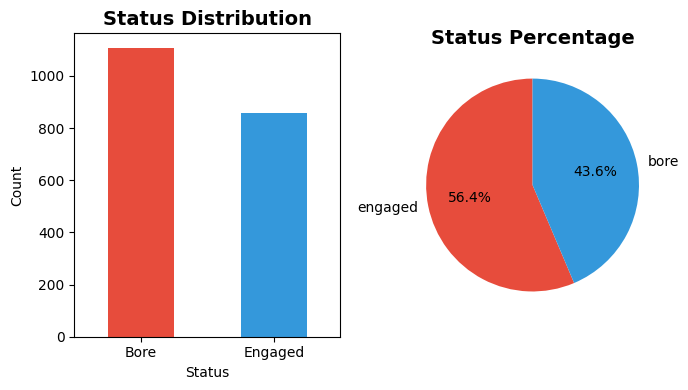

In [226]:
# status Distribution

fig, axes = plt.subplots(1, 2, figsize=(7, 4))

# Count plot
df['status'].value_counts().plot(kind='bar', ax=axes[0], color=['#e74c3c', '#3498db'])
axes[0].set_title('Status Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Status')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Bore', 'Engaged'], rotation=0)

# Percentage
status_pct = df['status'].value_counts(normalize=True) * 100
axes[1].pie(status_pct.values, labels=status_pct.index, autopct='%1.1f%%',
            startangle=90, colors=['#e74c3c', '#3498db'])
axes[1].set_title('Status Percentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

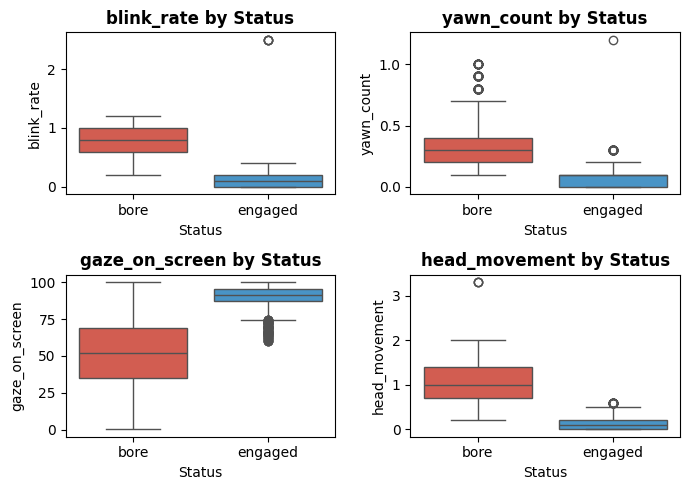

In [227]:
numerical_cols = ['blink_rate', 'yawn_count', 'gaze_on_screen', 'head_movement']

fig, axes = plt.subplots(2, 2, figsize=(7, 5))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols):
    sns.boxplot(data=df, x='status', y=col, ax=axes[idx], palette=['#e74c3c', '#3498db'])
    axes[idx].set_title(f'{col} by Status', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Status')
    axes[idx].set_ylabel(col)

plt.tight_layout()
plt.show()


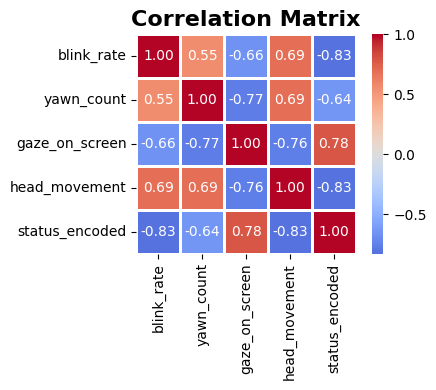

In [228]:
df_corr = df.copy()
df_corr['status_encoded'] = df_corr['status'].map({'bore': 0, 'engaged': 1})

corr_cols = numerical_cols + ['status_encoded']
correlation_matrix = df_corr[corr_cols].corr()

plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1)
plt.title('Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

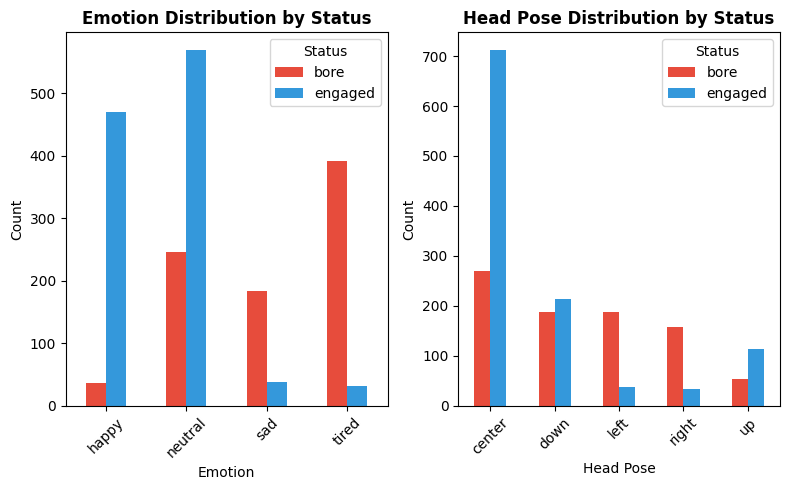

In [229]:
fig, axes = plt.subplots(1, 2, figsize=(8, 5))

# Emotion distribution by status
emotion_status = pd.crosstab(df['emotion'], df['status'])
emotion_status.plot(kind='bar', ax=axes[0], color=['#e74c3c', '#3498db'])
axes[0].set_title('Emotion Distribution by Status', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Emotion')
axes[0].set_ylabel('Count')
axes[0].legend(title='Status')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

# Head pose distribution by status
headpose_status = pd.crosstab(df['head_pose'], df['status'])
headpose_status.plot(kind='bar', ax=axes[1], color=['#e74c3c', '#3498db'])
axes[1].set_title('Head Pose Distribution by Status', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Head Pose')
axes[1].set_ylabel('Count')
axes[1].legend(title='Status')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

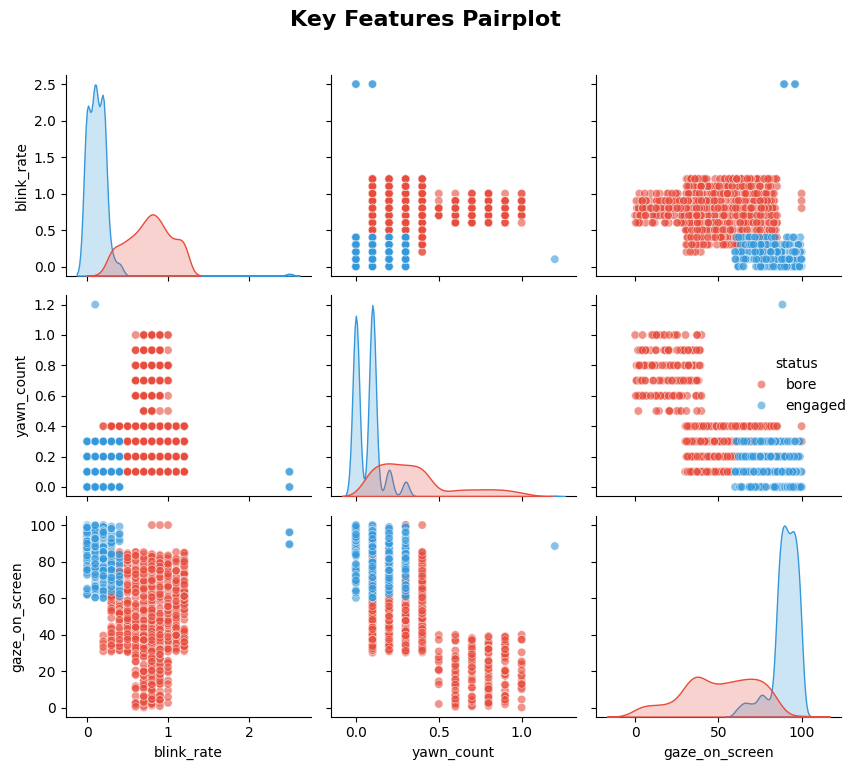

In [230]:
key_features = ['blink_rate', 'yawn_count', 'gaze_on_screen', 'status']

sns.pairplot(df[key_features], hue='status', palette=['#e74c3c', '#3498db'],
             diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle('Key Features Pairplot', y=1.02, fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

<Axes: >

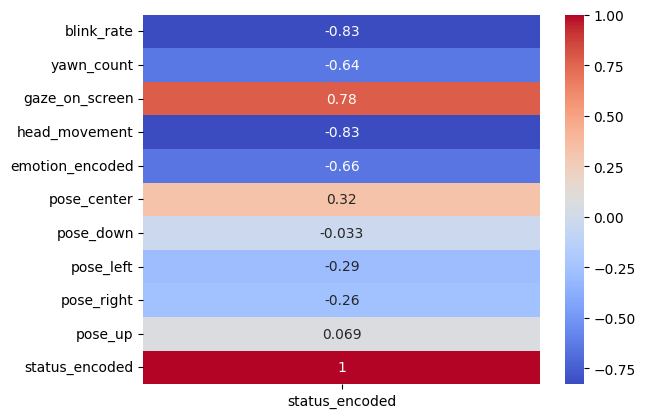

In [313]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr[['status_encoded']], annot=True, cmap='coolwarm')

## Feature Encoding

In [231]:
from sklearn.preprocessing import LabelEncoder

emotion_encoder = LabelEncoder()
df["emotion_encoded"] = emotion_encoder.fit_transform(df["emotion"])

In [232]:
df = pd.get_dummies(df, columns=["head_pose"], prefix="pose")

In [233]:
df["status_encoded"] = df["status"].map({"bore": 0, "engaged": 1})

In [234]:
df.head()

,emotion,blink_rate,yawn_count,gaze_on_screen,head_movement,status,emotion_encoded,pose_center,pose_down,pose_left,pose_right,pose_up,status_encoded
0,tired,0.5,0.3,41.3,1.4,bore,3,True,False,False,False,False,0
1,neutral,0.1,0.1,99.9,0.1,engaged,1,True,False,False,False,False,1
2,happy,0.1,0.1,88.3,0.0,engaged,0,False,True,False,False,False,1
3,tired,0.9,0.4,64.3,0.4,bore,3,False,True,False,False,False,0
4,happy,0.0,0.1,85.3,0.2,engaged,0,True,False,False,False,False,1


In [235]:
df = df.drop("emotion", axis=1)

# Data Splitting

In [236]:
X = df.drop(columns=["status", "status_encoded"])
y = df["status_encoded"]

In [248]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (1375, 10)
Test shape: (590, 10)


In [249]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Training

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report
)

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


===== RandomForest | Test Metrics =====
Accuracy : 0.963
ROC AUC  : 0.993

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       257
           1       0.99      0.95      0.97       333

    accuracy                           0.96       590
   macro avg       0.96      0.97      0.96       590
weighted avg       0.96      0.96      0.96       590


Confusion Matrix:
[[253   4]
 [ 18 315]]


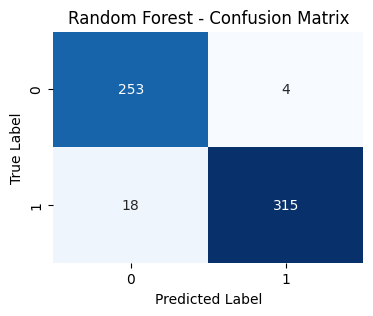

In [273]:
rf = RandomForestClassifier(
    n_estimators=20,
    max_depth=3,
    min_samples_split=30,
    min_samples_leaf=15,
    max_features='sqrt',
    min_impurity_decrease=0.05,
    max_leaf_nodes=10,
    ccp_alpha=0.01,
    random_state=42
)


rf.fit(X_train_scaled, y_train)


y_pred_rf = rf.predict(X_test_scaled)
y_pred_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]


print(f"Accuracy : {accuracy_score(y_test, y_pred_rf):.3f}")
print(f"ROC AUC  : {roc_auc_score(y_test, y_pred_proba_rf):.3f}")


print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
print("\nConfusion Matrix:")
print(cm)

# Plot confusion matrix for better visualization
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Accuracy : 0.966
ROC AUC  : 0.996

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       257
           1       0.96      0.98      0.97       333

    accuracy                           0.97       590
   macro avg       0.97      0.96      0.97       590
weighted avg       0.97      0.97      0.97       590


Confusion Matrix:
[[244  13]
 [  7 326]]


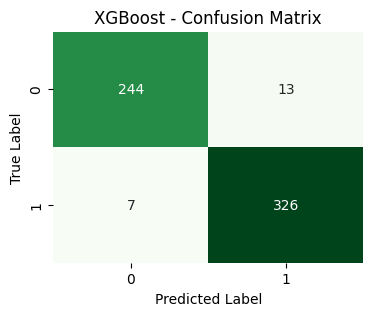

In [276]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

xgb = XGBClassifier(
    n_estimators=30,
    max_depth=2,
    learning_rate=0.01,
    subsample=0.5,
    colsample_bytree=0.5,
    reg_alpha=10,
    reg_lambda=10,
    min_child_weight=10,
    gamma=1,
    random_state=42
)


xgb.fit(X_train_scaled, y_train)


y_pred_xgb = xgb.predict(X_test_scaled)
y_pred_proba_xgb = xgb.predict_proba(X_test_scaled)[:, 1]


print(f"Accuracy : {accuracy_score(y_test, y_pred_xgb):.3f}")
print(f"ROC AUC  : {roc_auc_score(y_test, y_pred_proba_xgb):.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print("\nConfusion Matrix:")
print(cm_xgb)

# Plot Confusion Matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title("XGBoost - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Accuracy : 0.975
ROC AUC  : 0.998

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       257
           1       0.99      0.97      0.98       333

    accuracy                           0.97       590
   macro avg       0.97      0.98      0.97       590
weighted avg       0.97      0.97      0.97       590


Confusion Matrix:
[[253   4]
 [ 11 322]]


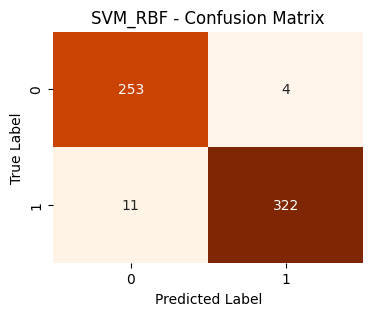

In [281]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

svm = SVC(
    C=0.1,
    kernel='rbf',
    gamma=0.01,
    probability=True,
    random_state=42
)


svm.fit(X_train_scaled, y_train)


y_pred_svm = svm.predict(X_test_scaled)
y_pred_proba_svm = svm.predict_proba(X_test_scaled)[:, 1]


print(f"Accuracy : {accuracy_score(y_test, y_pred_svm):.3f}")
print(f"ROC AUC  : {roc_auc_score(y_test, y_pred_proba_svm):.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
print("\nConfusion Matrix:")
print(cm_svm)

# Plot Confusion Matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Oranges', cbar=False)
plt.title("SVM_RBF - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [282]:
train_acc = svm.score(X_train_scaled, y_train)
test_acc = svm.score(X_test_scaled, y_test)
print(train_acc, test_acc)

0.984 0.9745762711864406


choose the SVM_RBF (Heavy Regularization) model — it delivers the highest accuracy (0.975), best ROC AUC (0.998), and the most balanced precision–recall performance, indicating strong generalization with minimal overfitting.

# Model Saved

In [285]:
import joblib

joblib.dump({'model': svm, 'scaler': scaler}, 'svm_with_scaler.pkl')

['svm_with_scaler.pkl']

# Model Pipeline

In [329]:
import joblib
import numpy as np
import pandas as pd

bundle = joblib.load("svm_with_scaler.pkl")
model = bundle["model"]
scaler = bundle["scaler"]

emotion_map = {
    "happy": 0,
    "neutral": 1,
    "sad": 2,
    "tired": 3
}

pose_cols = ["pose_center", "pose_down", "pose_left", "pose_right", "pose_up"]

feature_order = [
    "blink_rate", "yawn_count", "gaze_on_screen", "head_movement",
    "emotion_encoded", "pose_center", "pose_down", "pose_left",
    "pose_right", "pose_up"
]

def predict_attention(blink_count, yawn_count, gaze_on_screen, head_movement_count,
                      emotion, head_pose):
    blink_rate = blink_count / 10
    yawn_rate = yawn_count / 10
    head_movement_rate = head_movement_count / 10

    emotion_encoded = emotion_map.get(emotion.lower(), 1)

    pose_vector = {col: 0 for col in pose_cols}
    pose_key = f"pose_{head_pose.lower()}"
    if pose_key in pose_vector:
        pose_vector[pose_key] = 1

    input_data = pd.DataFrame([{
        "blink_rate": blink_rate,
        "yawn_count": yawn_rate,
        "gaze_on_screen": gaze_on_screen,
        "head_movement": head_movement_rate,
        "emotion_encoded": emotion_encoded,
        **pose_vector
    }])[feature_order]

    scaled_input = scaler.transform(input_data)
    pred = model.predict(scaled_input)[0]
    label = "bore" if pred == 0 else "engaged"

    return {
        "prediction": label,
        "input_raw": input_data.to_dict(orient="records")[0],
        "input_scaled": scaled_input.tolist()[0]
    }


In [336]:
result = predict_attention(
    blink_count=9,
    yawn_count=3,
    gaze_on_screen=45,
    head_movement_count=4,
    emotion="tired",
    head_pose="down"
)

print("Predicted Status:", result["prediction"])

Predicted Status: bore
